#### Generative Adversarial Networks (GANs)




In [1]:

import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
from torchvision import transforms, datasets ,utils


 

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

print('Done')

Done


## Dataset
 

In [2]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    
    noise=2*torch.rand(batch_size, dim)-1
    return noise



Make sure noise is the correct shape and type:

In [3]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')
    
test_sample_noise()

All tests passed!


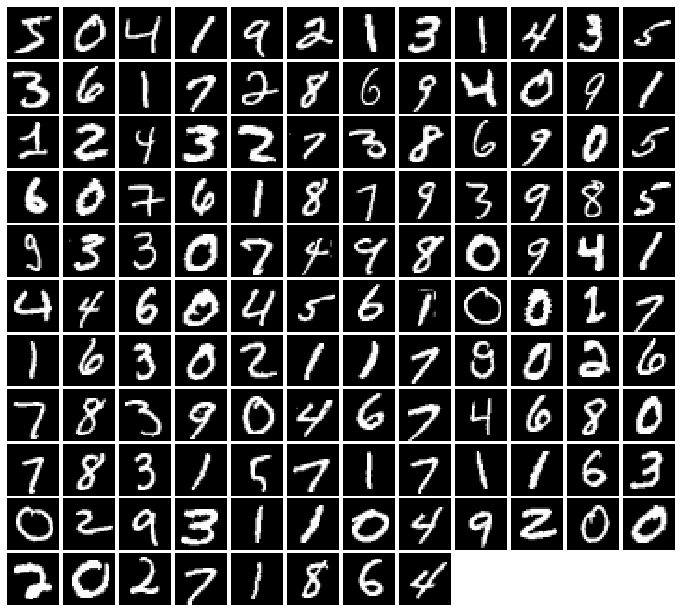

In [4]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 100
batch_size = 128

mnist_train = dset.MNIST('./data/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./data/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Flatten



In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform(m.weight.data)

## CPU / GPU


In [6]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!


#### Discriminator
  
* Reshape into image tensor (Use Unflatten!)
* 36 Filters, 4x4, Stride 1, Leaky ReLU(alpha=0.02)
* Max Pool 2x2, Stride 2
* 72 Filters, 4x4, Stride 1, Leaky ReLU(alpha=0.02)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected output size 1024, Leaky ReLU(alpha=0.02)
* Fully Connected output size 1

In [1]:
def build_dc_classifier():#mnist
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
    return nn.Sequential(
        
        Unflatten(batch_size, 1, 28, 28),        
        nn.Conv2d(1, 36,stride=1, kernel_size=4),
        nn.LeakyReLU(negative_slope=0.02, inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(36, 72, stride=1, kernel_size=4),
        nn.LeakyReLU(negative_slope=0.02, inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Flatten(),
        nn.Linear(1152,1024),
        nn.LeakyReLU(negative_slope=0.02, inplace=True),
        nn.Linear(1024,1)
        
        
    )

Check the number of parameters in your classifier as a sanity check:

In [8]:
def test_dc_classifer(true_count=1223853):
    model = build_dc_classifier()
    cur_count = count_params(model)
    if cur_count != true_count:
        print(cur_count)
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_classifer()

Correct number of parameters in generator.


#### Generator.


* Fully connected of size 1500, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 120, ReLU
* BatchNorm
* Reshape into Image Tensor using Unflatten(), you should figure out the parameters of N,C,H and W.
* 60 ConvTranspose2d filters of 4x4, stride 2,  padding=1, ReLU
* BatchNorm
* 1 ConvTranspose2d filter of 4x4, stride 2, padding=1, TanH
* Should have a 28x28x1 image, reshape back into 784 vector

In [9]:
def build_dc_generator(noise_dim=NOISE_DIM):#mnist
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    return nn.Sequential(
        #########3rd TO DO (10 points)###########
        nn.Linear(NOISE_DIM, 1500),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(1500),
        nn.Linear(1500, 7*7*120),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(7*7*120),
        Unflatten(batch_size, 120, 7, 7),
        nn.ConvTranspose2d(120, 60, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(60),
        nn.ConvTranspose2d(60, 1, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
        Flatten()

       
        
    )

Check the number of parameters in your generator as a sanity check:

In [10]:
def test_dc_generator(true_count=9108481):
    model = build_dc_generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print(cur_count)
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_generator()

Correct number of parameters in generator.


# GAN Loss



In [11]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Variable of shape (N, ) giving scores.
    - target: PyTorch Variable of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Variable containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()



In [12]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    ##########4th TO DO (5 points)#############

    true_labels = Variable(torch.ones(logits_real.shape[0])).type(dtype)
    false_labels = Variable(torch.zeros(logits_fake.shape[0])).type(dtype)
    return bce_loss(logits_real, true_labels) + bce_loss(logits_fake, false_labels)
    
    

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing the (scalar) loss for the generator.
    """
    #-log(1 / (1 + exp(-x)))
    #####5th TO DO (3 points)########
    fake_labels = Variable(torch.ones(logits_fake.shape[0])).type(dtype)
    return bce_loss(logits_fake, fake_labels)

Test your generator and discriminator loss. You should see errors < 1e-7.

In [13]:
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(Variable(torch.Tensor(logits_real)).type(dtype),
                                Variable(torch.Tensor(logits_fake)).type(dtype)).data.cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

#test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
  #                      answers['d_loss_true'])

In [14]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(Variable(torch.Tensor(logits_fake)).type(dtype)).data.cpu().numpy()
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

#test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

# Optimizing our loss


In [15]:

def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 2e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    #########6th TO DO (3 points)###############
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.9999))  
    return optimizer

# Training a GAN!



In [16]:
import time
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=100, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    t1=time.time()
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            t2=time.time()
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = Variable(x).type(dtype)
            real_data=real_data.view(batch_size,1,784)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed)
            fake_images=fake_images.detach()
            
            logits_fake = D(fake_images.view(batch_size, 1, 784))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 784))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.data[0],g_error.data[0]))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print('total time: %.2f'%(time.time()-t1))
                print('100 iter time: %.2f'%(time.time()-t2))
                print()
            iter_count += 1

This would takes about 1 hour on one cpu. In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000.

dtype  <class 'torch.cuda.FloatTensor'>


/home/h4k3r/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/home/h4k3r/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


start training
Iter: 0, D: 1.362, G:0.9945


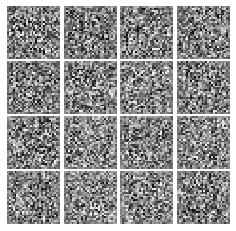

total time: 0.72
100 iter time: 0.72

Iter: 250, D: 1.344, G:0.6641


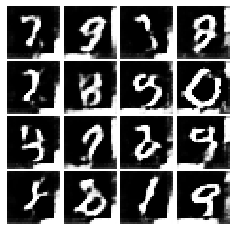

total time: 26.92
100 iter time: 0.70

Iter: 500, D: 1.22, G:0.993


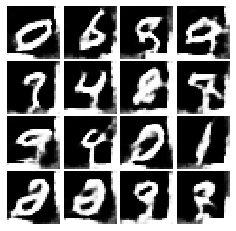

total time: 42.47
100 iter time: 0.58

Iter: 750, D: 1.255, G:0.8218


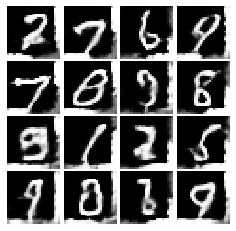

total time: 58.06
100 iter time: 0.63

Iter: 1000, D: 1.255, G:0.7937


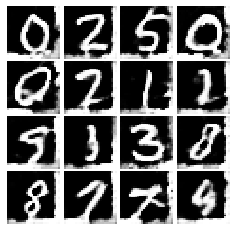

total time: 73.70
100 iter time: 0.60

Iter: 1250, D: 1.279, G:0.9107


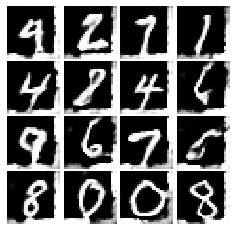

total time: 89.48
100 iter time: 0.59

Iter: 1500, D: 1.211, G:0.8679


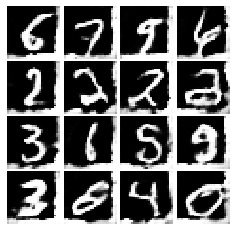

total time: 105.66
100 iter time: 0.63

Iter: 1750, D: 1.161, G:1.309


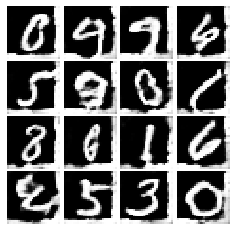

total time: 121.48
100 iter time: 0.58

Iter: 2000, D: 1.149, G:0.9255


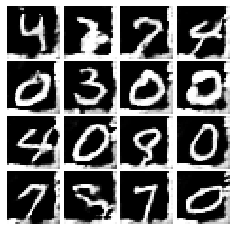

total time: 137.31
100 iter time: 0.62

Iter: 2250, D: 1.18, G:0.8846


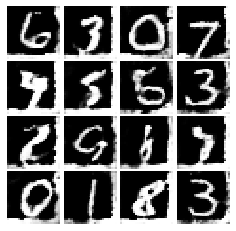

total time: 153.08
100 iter time: 0.59

Iter: 2500, D: 1.042, G:1.023


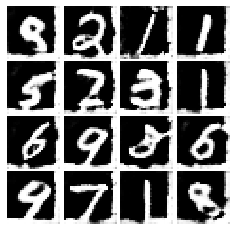

total time: 168.86
100 iter time: 0.59

Iter: 2750, D: 0.9429, G:1.605


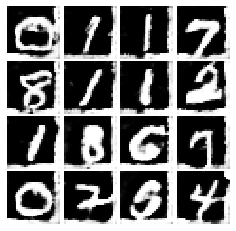

total time: 184.76
100 iter time: 0.66

Iter: 3000, D: 1.54, G:1.744


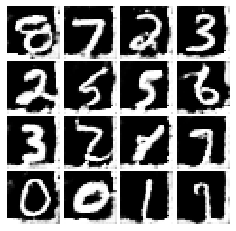

total time: 200.58
100 iter time: 0.61

Iter: 3250, D: 1.019, G:1.379


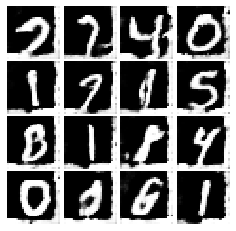

total time: 216.49
100 iter time: 0.65

Iter: 3500, D: 0.8277, G:1.366


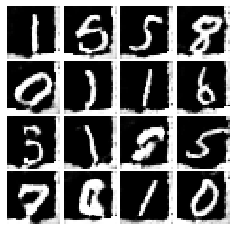

total time: 232.35
100 iter time: 0.62

Iter: 3750, D: 0.6329, G:1.407


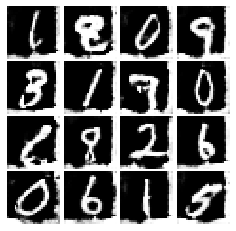

total time: 248.22
100 iter time: 0.62

Iter: 4000, D: 0.747, G:1.683


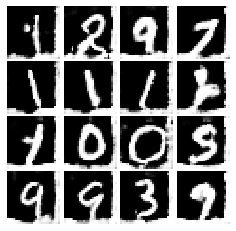

total time: 264.11
100 iter time: 0.67

Iter: 4250, D: 0.6827, G:1.877


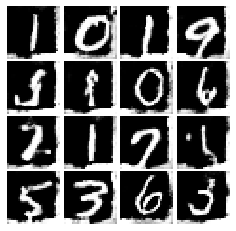

total time: 279.97
100 iter time: 0.63

Iter: 4500, D: 0.655, G:2.121


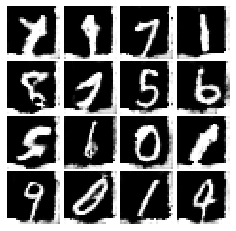

total time: 295.89
100 iter time: 0.66

Iter: 4750, D: 0.5898, G:1.939


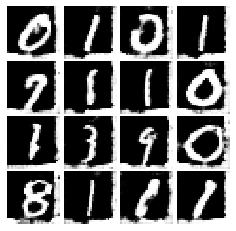

total time: 311.76
100 iter time: 0.61

Iter: 5000, D: 0.5231, G:1.8


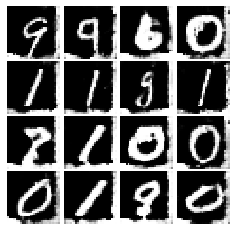

total time: 327.61
100 iter time: 0.61

Iter: 5250, D: 0.6252, G:1.682


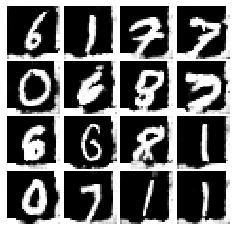

total time: 343.51
100 iter time: 0.66

Iter: 5500, D: 0.6623, G:2.103


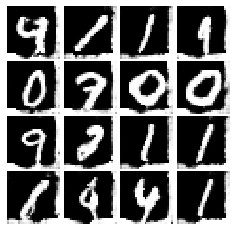

total time: 359.36
100 iter time: 0.61

Iter: 5750, D: 0.5262, G:2.272


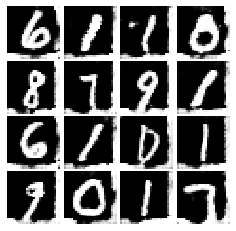

total time: 375.23
100 iter time: 0.64

Iter: 6000, D: 0.5345, G:1.892


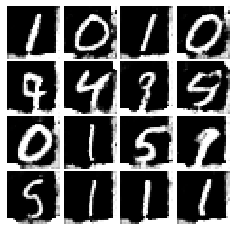

total time: 391.06
100 iter time: 0.61

Iter: 6250, D: 0.6915, G:2.41


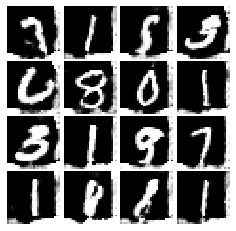

total time: 407.11
100 iter time: 0.64

Iter: 6500, D: 0.5892, G:3.096


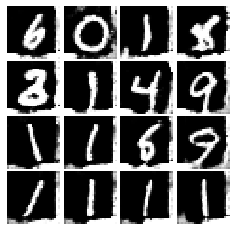

total time: 423.20
100 iter time: 0.68

Iter: 6750, D: 0.2754, G:2.965


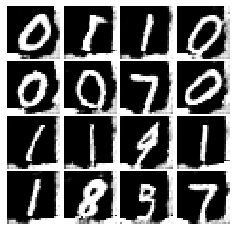

total time: 439.01
100 iter time: 0.61

Iter: 7000, D: 0.5512, G:2.323


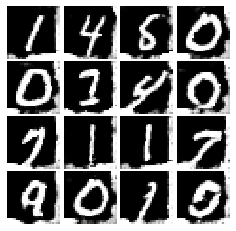

total time: 454.91
100 iter time: 0.70

Iter: 7250, D: 0.5713, G:2.838


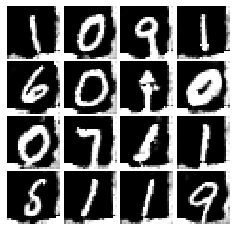

total time: 470.89
100 iter time: 0.62

Iter: 7500, D: 0.5023, G:3.019


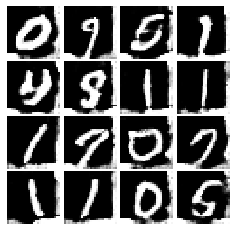

total time: 486.78
100 iter time: 0.62

Iter: 7750, D: 0.4097, G:3.784


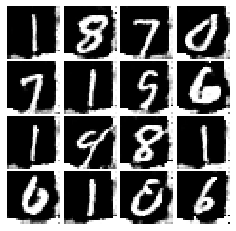

total time: 502.76
100 iter time: 0.72

Iter: 8000, D: 0.3147, G:3.229


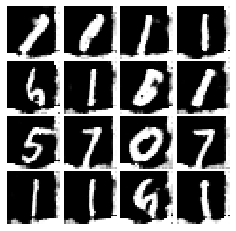

total time: 518.71
100 iter time: 0.67

Iter: 8250, D: 0.5374, G:3.059


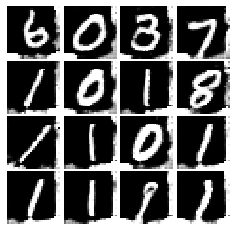

total time: 534.65
100 iter time: 0.67

Iter: 8500, D: 0.3291, G:3.223


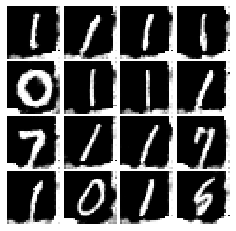

total time: 550.57
100 iter time: 0.63

Iter: 8750, D: 0.3317, G:2.538


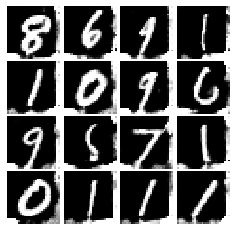

total time: 566.47
100 iter time: 0.63

Iter: 9000, D: 0.3794, G:2.782


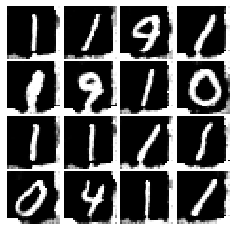

total time: 582.44
100 iter time: 0.71

Iter: 9250, D: 0.2707, G:3.582


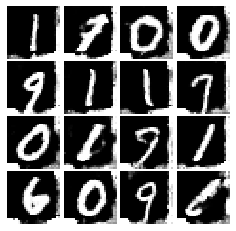

total time: 598.37
100 iter time: 0.67

Iter: 9500, D: 0.4725, G:3.257


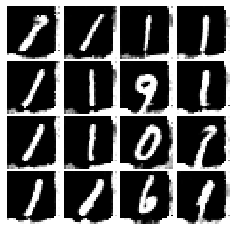

total time: 614.35
100 iter time: 0.71

629.6236548423767


In [17]:
# Make the discriminator
print('dtype ',dtype)
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
# Make the generator
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)
# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)
t1=time.time()
print('start training')
# Run it!
run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=25)
print(time.time()-t1)